# MSDE631 SQL-NoSQL | Regis University
### Instructor: Dr. Busch

TITLE  | Date | Author |   Notes |
:-----:|:----:|:------:|:-------:|
Project 7: PDA to Graph transformation |20 April 2023 | Ken Dizon | 

**TASK / Content**

Transform you relation database you created for your PDA into a graph database.

1. Show the mapping of tables, rows and attributes to the nodes, relations and properties.
2. Draw a graph that represent you PDA. 
3. Implement your graph into Neo4J by importing data from CSV files.

Submit the following:
- Your RDBMS PDA to Graph entities mapping.
- Your PDA graph.
- Screenshots of the implemented graph in Neo4J.
- The code you used to implement the graph.
- Your CSV files.

In [1]:
# Load Packages
from neo4j import __version__ as neo4j_version
from neo4j import GraphDatabase
print('nejo4j version:', neo4j_version)

import getpass
import pandas as pd
import csv
import json
from pprint import pprint

nejo4j version: 5.7.0


Note we first created a project and DB in the Neo4j GUI:

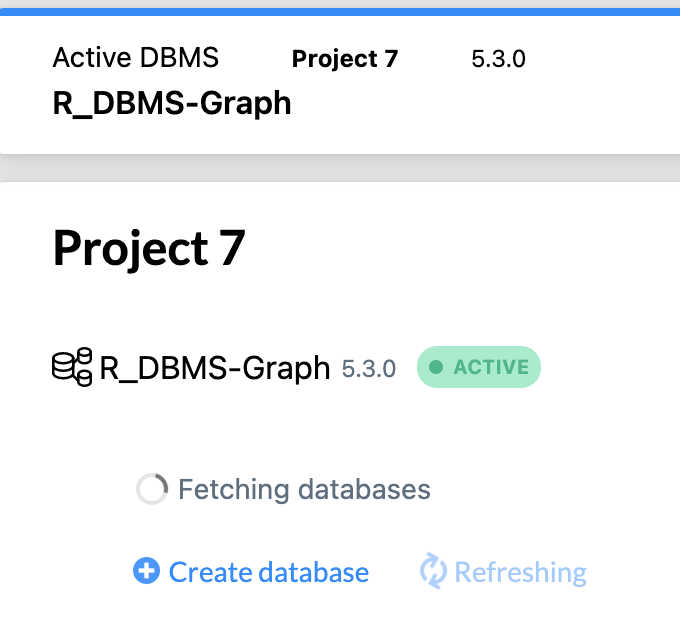

In [2]:
# Connect to a Neo4j database:
uri = 'bolt://localhost:7687'
user = "neo4j"  
password = getpass.getpass('Enter Password: ')

driver = GraphDatabase.driver(uri, auth=(user, password))

Enter Password:  ········


In [3]:
product_data = 'Generated_Data/product_data.txt'
clinic_data = 'Generated_Data/clinic_data.txt'
customer_data = 'Generated_Data/customer_data.txt'
orderdetails_data = 'Generated_Data/orderdetails_data.txt'
orders_data = 'Generated_Data/orders_data.txt'

In [4]:
# Check data
def view_file(file_path):
    with open(file_path, "r") as file:
        print(f"Contents of {file_path} (first 5):")
        for i in range(5):
            line = file.readline().strip()
            if line:
                print(line)
            else:
                break

view_file(clinic_data)

Contents of Generated_Data/clinic_data.txt (first 5):
1;Garcia, Harrell and Phillips;3197 Koch Tunnel Apt. 731;New Mikeview;Nevada;54039;520-541-1189x358
2;Moore LLC;1582 Noah Orchard;Brianland;Hawaii;93431;108-327-9309
3;Kim, Taylor and Carter;099 Jonathan Wells;North Emilyberg;West Virginia;43320;074-315-0439x527
4;Phillips, Edwards and Hoffman;70858 Neal Lights Apt. 480;South Thomas;Texas;19190;001-220-765-4080x40829
5;Brown PLC;85134 Morris Way;West Angelaberg;Texas;82725;(392)198-2487x7041


### Insert Data into Neo4j

In [5]:
with open(product_data, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        with driver.session() as session:
            session.run("""
                CREATE (p:Product {product_id: $product_id, name: $name, description: $description, price: $price})
            """, product_id=row[0], name=row[1], description=row[2], price=row[3])

In [6]:
with open(clinic_data, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        with driver.session() as session:
            session.run("""
                CREATE (c:Clinic {clinic_id: $clinic_id, name: $name, address: $address,
                city: $city, state: $state, zip: $zip, phone: $phone})
            """, clinic_id=row[0], name=row[1], address=row[2], city=row[3], state=row[4], zip=row[5], phone=row[6])

In [7]:
with open(customer_data, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        with driver.session() as session:
            session.run("""
                MATCH (c:Clinic {clinic_id: $clinic_id})
                CREATE (cu:Customer {customer_id: $customer_id, start_date: $start_date, first_name: $first_name,
                last_name: $last_name, dob: $dob, phone: $phone, email: $email})
                MERGE (cu)-[:BELONGS_TO]->(c)
            """, clinic_id=row[7], customer_id=row[0], start_date=row[1], first_name=row[2],
               last_name=row[3], dob=row[4], phone=row[5], email=row[6])

In [8]:
with open(orderdetails_data, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        with driver.session() as session:
            session.run("""
                MATCH (p:Product {product_id: $product_id})
                MATCH (o:Orders {order_id: $order_id})
                CREATE (od:OrderDetails {order_details_id: $order_details_id, quantity: $quantity})
                MERGE (od)-[:ORDERED_PRODUCT]->(p)
                MERGE (od)-[:BELONGS_TO_ORDER]->(o)
            """, product_id=row[1], order_id=row[2], order_details_id=row[0], quantity=row[3])

In [9]:
with open(orders_data, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        with driver.session() as session:
            session.run("""
                MATCH (c:Customer {customer_id: $customer_id})
                CREATE (o:Orders {order_id: $order_id, order_date: $order_date})
                MERGE (o)-[:PLACED_BY]->(c)
            """, order_id=row[0], order_date=row[1], customer_id=row[2])

## Neo4j GUI

- High overview of the database:
    * Red = Product (bottom)
    * Orange = Clinics
    * Green = Customers
    * Blue = relationships of Customers to clinic
    
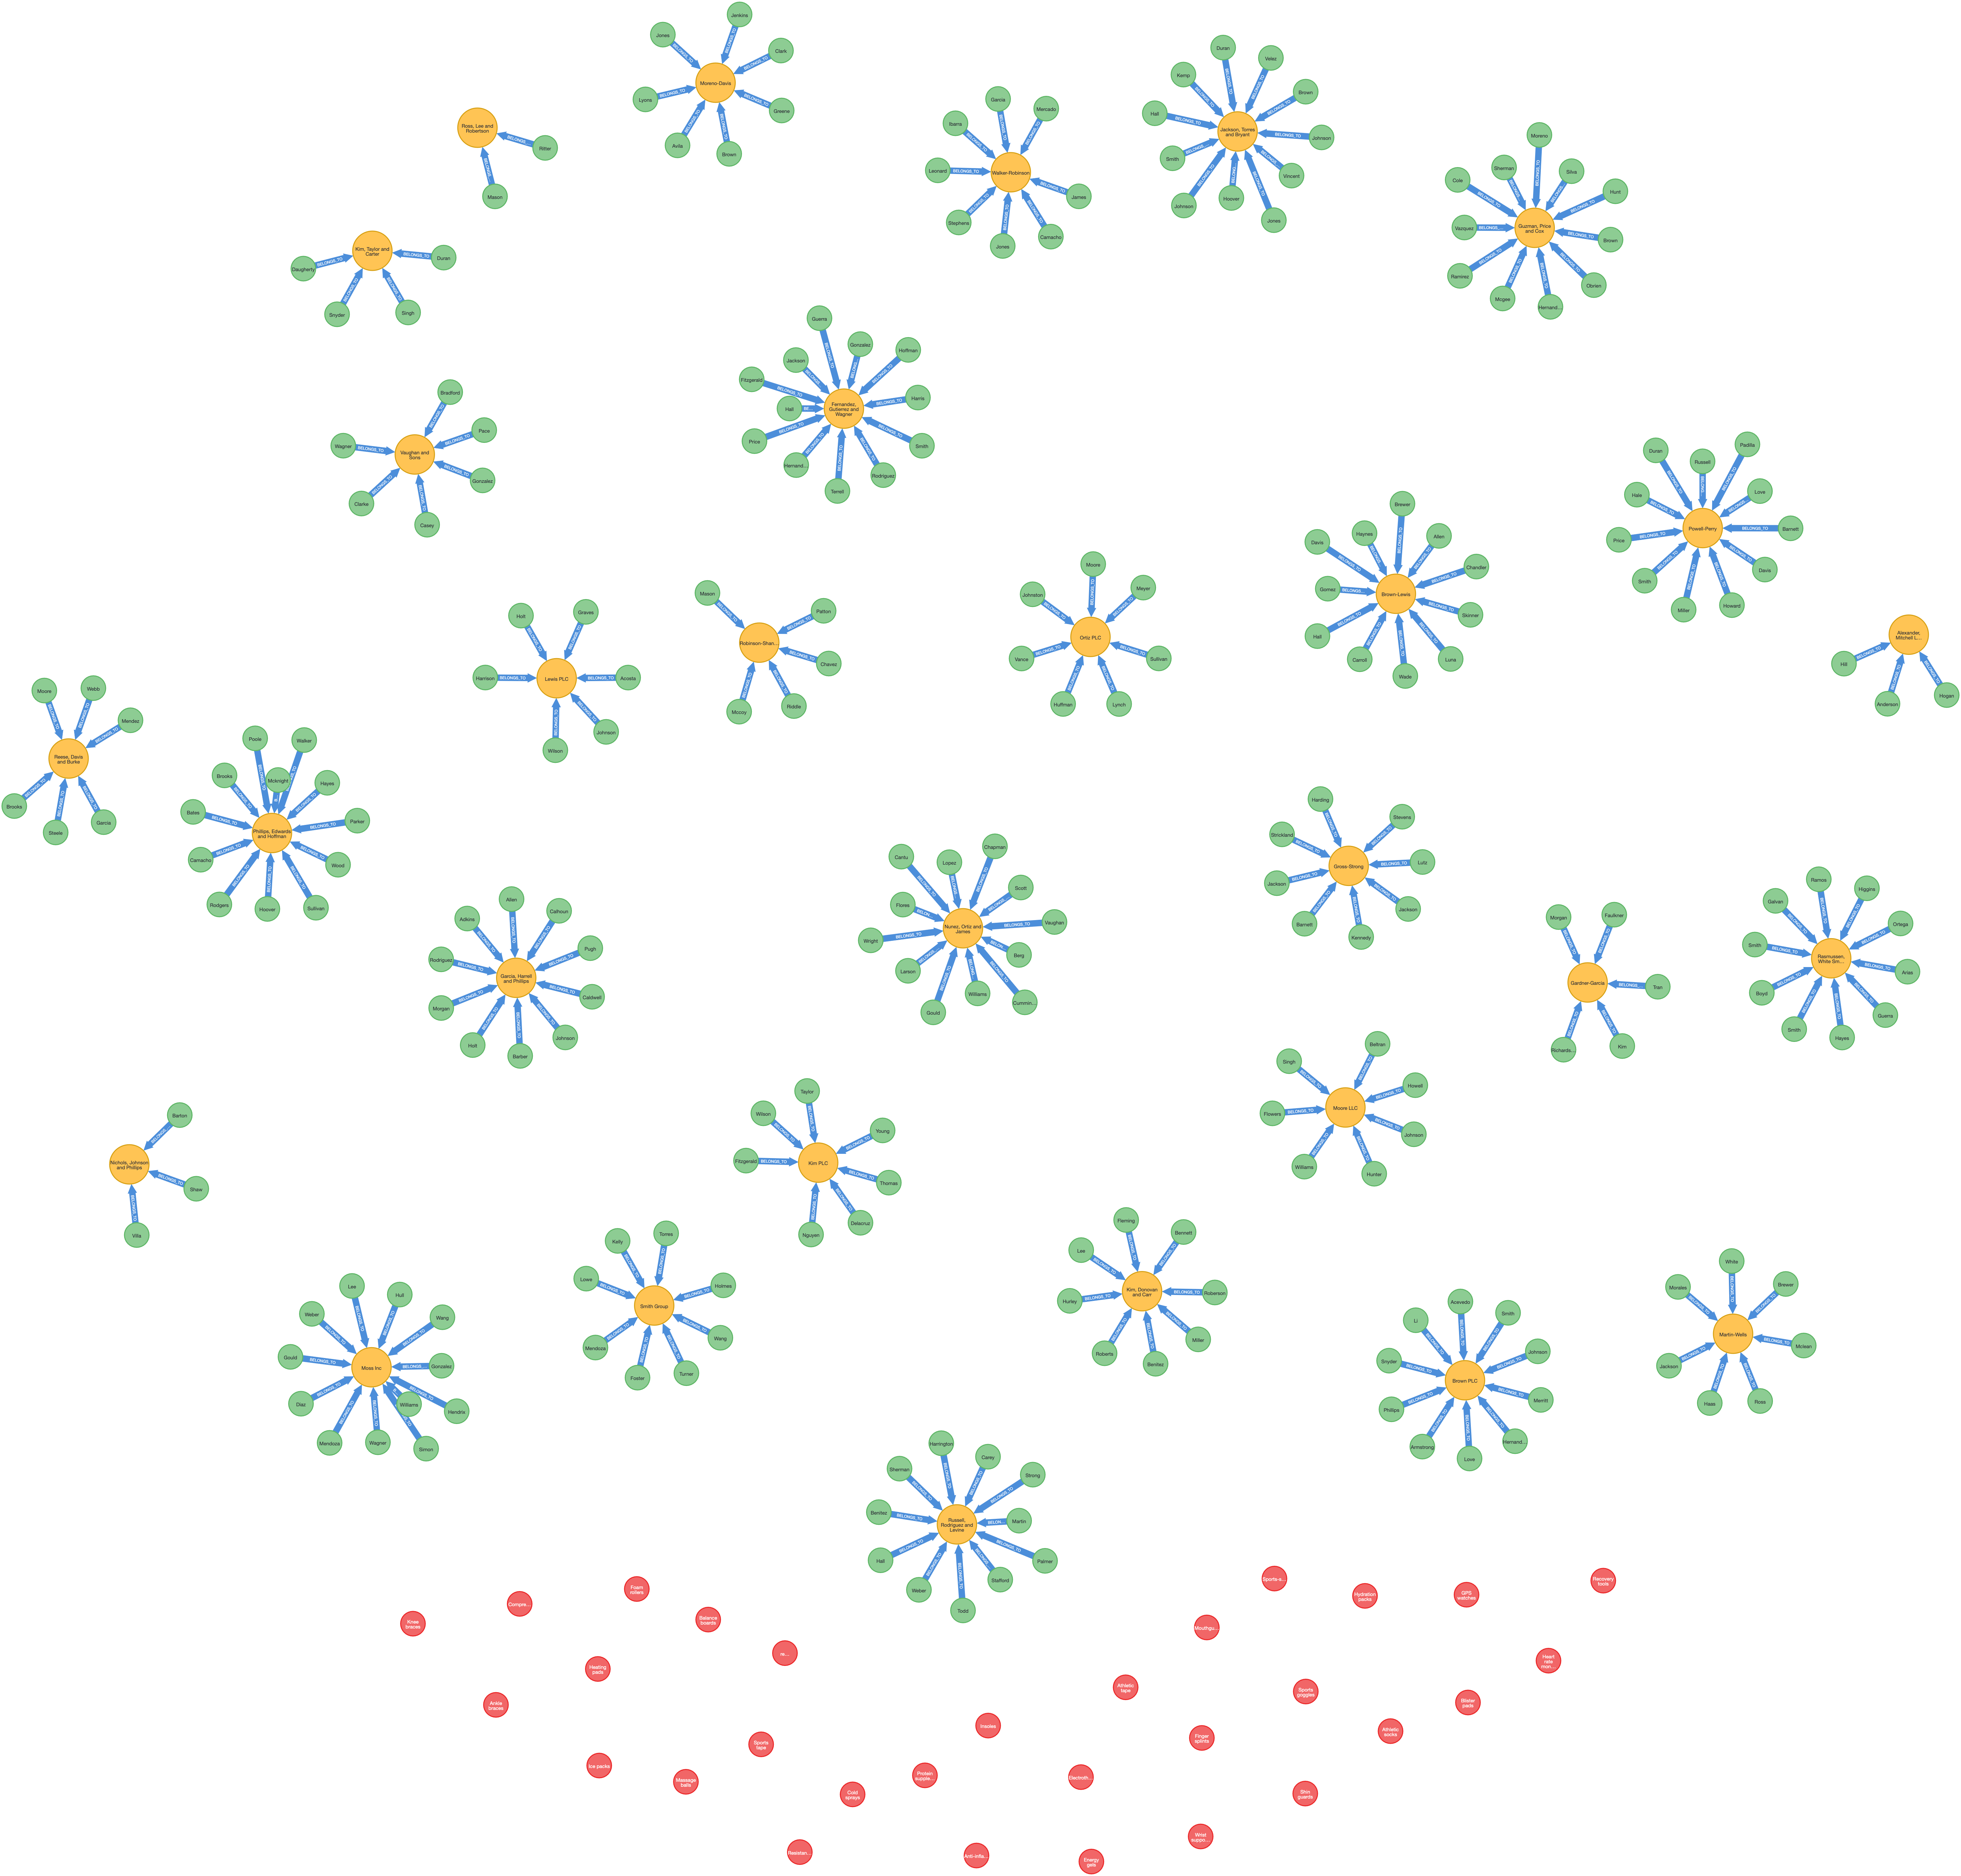

In [10]:
# Create a relationship between a customer and a purchased product
def create_purchase_relationship(customer_id, product_id, quantity):
    with driver.session() as session:
        session.run("""
            MATCH (c:Customer {customer_id: $customer_id})
            MATCH (p:Product {product_id: $product_id})
            CREATE (c)-[:PURCHASED {quantity: $quantity}]->(p)
        """, customer_id=customer_id, product_id=product_id, quantity=quantity)

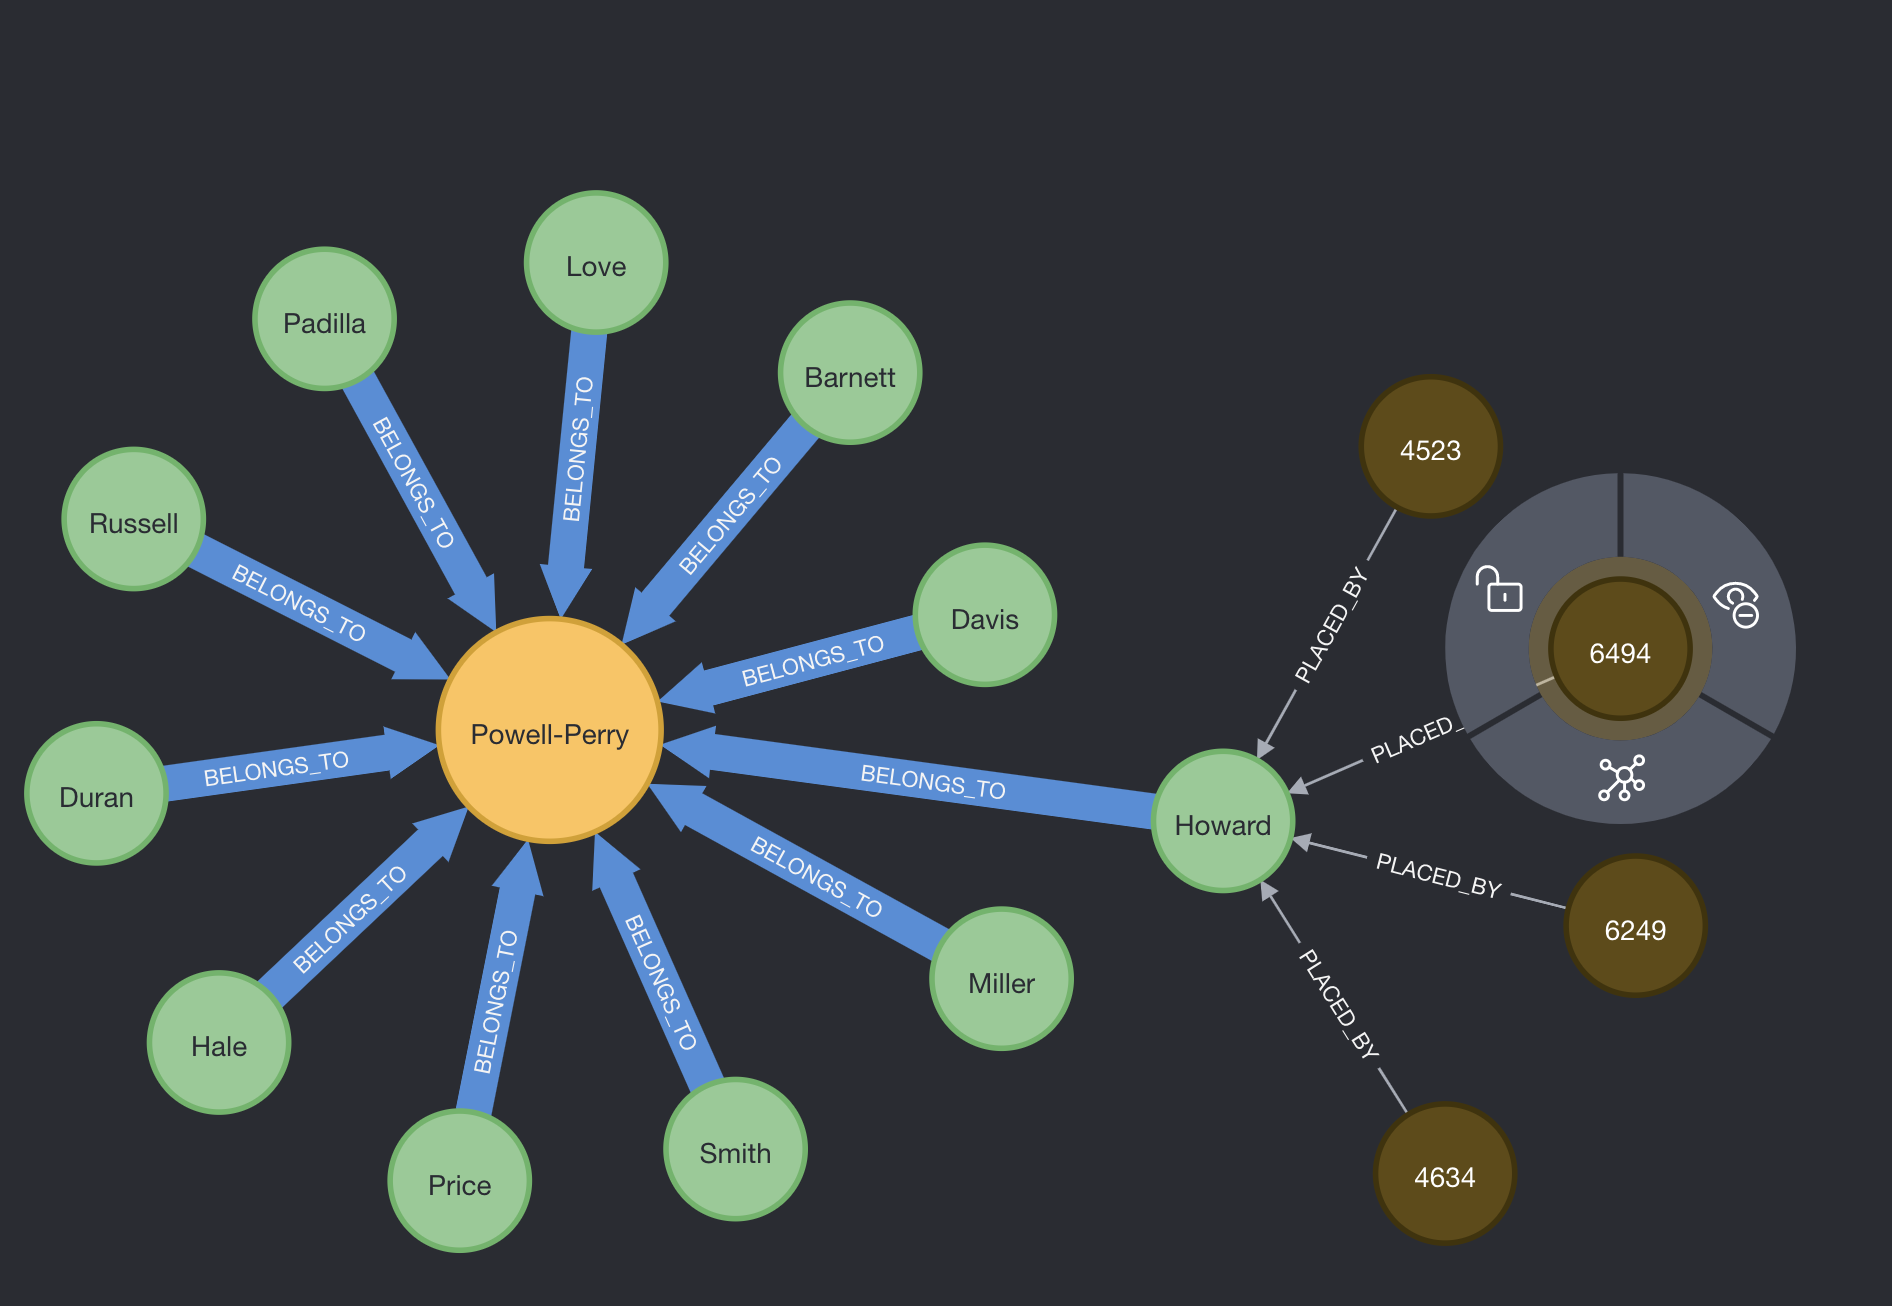

**High Resolution**
- Here is an image of a clinic (Single Node): `c:Clinic{name:"Powell-Perry"}`
    * Displays all customers (MultipleNode)
        * BELONGS_TO (Relationship)
- Within customer `cu:Customer{last_name: "Howard""` 
    * Displays orders PLACED_BY (Relationship)
        * Node Order_ID